In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
from experiments.exp_basic import Exp_Basic
from experiments.exp_long_term_forecasting_partial import Exp_Long_Term_Forecast_Partial
from experiments.exp_long_term_forecasting import Exp_Long_Term_Forecast
from data_provider.data_factory import data_provider
import random
import torch
import sys
import os

sys.argv = ['']

fix_seed = 2023
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

In [2]:
parser = argparse.ArgumentParser(description='iTransformer')

# basic config
parser.add_argument('--is_training', type=int, required=False, default=1, help='status')
parser.add_argument('--model_id', type=str, required=False, default='Exchange_96_96', help='model id')
parser.add_argument('--model', type=str, required=False, default='iTransformer',
                    help='model name, options: [iTransformer, iInformer, iReformer, iFlowformer, iFlashformer]')

# data loader
parser.add_argument('--data', type=str, required=False, default='custom', help='dataset type')
parser.add_argument('--root_path', type=str, default='D:/FPT/SU24/DSP391m/code/crawl/data/clean/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='df_combine.csv', help='data csv file')
parser.add_argument('--features', type=str, default='S',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='Sell', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length') # no longer needed in inverted Transformers
parser.add_argument('--pred_len', type=int, default=96, help='prediction sequence length')

# model define
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=7, help='output size') # applicable on arbitrary number of variates in inverted Transformers
parser.add_argument('--d_model', type=int, default=128, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=128, help='dimension of fcn')
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.1, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')
parser.add_argument('--itr', type=int, default=1, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='Exp', help='exp description')
parser.add_argument('--loss', type=str, default='MSE', help='loss function')
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)

# GPU
parser.add_argument('--use_gpu', type=bool, default=False, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

# iTransformer
parser.add_argument('--exp_name', type=str, required=False, default='partial_train',
                    help='experiemnt name, options:[MTSF, partial_train]')
parser.add_argument('--channel_independence', type=bool, default=False, help='whether to use channel_independence mechanism')
parser.add_argument('--inverse', action='store_true', help='inverse output data', default=False)
parser.add_argument('--class_strategy', type=str, default='projection', help='projection/average/cls_token')
parser.add_argument('--target_root_path', type=str, default='D:/FPT/SU24/DSP391m/code/crawl/data/clean/', help='root path of the data file')
parser.add_argument('--target_data_path', type=str, default='df_combine.csv', help='data file')
parser.add_argument('--efficient_training', type=bool, default=False, help='whether to use efficient_training (exp_name should be partial train)') # See Figure 8 of our paper for the detail
parser.add_argument('--use_norm', type=int, default=True, help='use norm and denorm')
parser.add_argument('--partial_start_index', type=int, default=0, help='the start index of variates for partial training, '
                                                                        'you can select [partial_start_index, min(enc_in + partial_start_index, N)]')
args = parser.parse_args()

In [3]:
setting = '{}_{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
            args.model_id,
            args.model,
            args.data,
            args.features,
            args.seq_len,
            args.label_len,
            args.pred_len,
            args.d_model,
            args.n_heads,
            args.e_layers,
            args.d_layers,
            args.d_ff,
            args.factor,
            args.embed,
            args.distil,
            args.des,
            args.class_strategy, 0)
setting

'Exchange_96_96_iTransformer_custom_S_ft96_sl48_ll96_pl128_dm8_nh2_el1_dl128_df1_fctimeF_ebTrue_dtExp_projection_0'

In [4]:
exp = Exp_Long_Term_Forecast_Partial(args)
exp.model.load_state_dict(torch.load(os.path.join('./checkpoints/' + setting, 'checkpoint.pth')))

Use CPU


<All keys matched successfully>

In [5]:
exp.test(setting)

border1s:  [0, 3312, 3594]
border1:  3594
border2s:  [3408, 3690, 4010]
border2:  4010
test 225
test shape: (225, 1, 96, 1) (225, 1, 96, 1)
test shape: (225, 96, 1) (225, 96, 1)
mse:0.22561483085155487, mae:0.3663773536682129


In [6]:
args.is_training = 0 
exp = Exp_Long_Term_Forecast_Partial(args)
exp.model.load_state_dict(torch.load(os.path.join('./checkpoints/' + setting, 'checkpoint.pth')))
exp.predict(setting)

Use CPU
3914
4010
pred 1
Inverse: [[[24513.121]
  [24475.002]
  [24450.746]
  [24462.473]
  [24417.855]
  [24404.34 ]
  [24412.068]
  [24517.258]
  [24448.295]
  [24443.7  ]
  [24414.336]
  [24474.293]
  [24470.059]
  [24450.928]
  [24397.625]
  [24469.988]
  [24509.7  ]
  [24425.836]
  [24479.574]
  [24437.246]
  [24471.914]
  [24463.2  ]
  [24406.28 ]
  [24430.477]
  [24483.662]
  [24333.018]
  [24490.002]
  [24472.504]
  [24424.98 ]
  [24554.564]
  [24403.623]
  [24460.441]
  [24452.803]
  [24369.318]
  [24469.629]
  [24427.67 ]
  [24458.916]
  [24424.385]
  [24425.16 ]
  [24539.262]
  [24416.113]
  [24387.44 ]
  [24474.74 ]
  [24534.635]
  [24451.924]
  [24480.469]
  [24544.664]
  [24430.332]
  [24476.758]
  [24409.992]
  [24504.705]
  [24403.629]
  [24508.496]
  [24413.328]
  [24477.883]
  [24436.355]
  [24435.76 ]
  [24538.85 ]
  [24359.96 ]
  [24431.285]
  [24477.707]
  [24550.691]
  [24514.885]
  [24501.783]
  [24516.932]
  [24421.637]
  [24378.676]
  [24497.395]
  [24392.176]


In [7]:
mae, mse, rmse, mape, mspe = np.load(os.path.join('results/' + setting, 'metrics.npy'))
preds = np.load(os.path.join('results/' + setting, 'pred.npy'))
trues = np.load(os.path.join('results/' + setting, 'true.npy'))
real_pred = np.load(os.path.join('results/' + setting, 'real_prediction.npy'))
train_loss = np.load(os.path.join('results/' + setting, 'train_loss.npy'))
val_loss = np.load(os.path.join('results/' + setting, 'val_loss.npy'))

In [8]:
real_pred

array([[[24513.121],
        [24475.002],
        [24450.746],
        [24462.473],
        [24417.855],
        [24404.34 ],
        [24412.068],
        [24517.258],
        [24448.295],
        [24443.7  ],
        [24414.336],
        [24474.293],
        [24470.059],
        [24450.928],
        [24397.625],
        [24469.988],
        [24509.7  ],
        [24425.836],
        [24479.574],
        [24437.246],
        [24471.914],
        [24463.2  ],
        [24406.28 ],
        [24430.477],
        [24483.662],
        [24333.018],
        [24490.002],
        [24472.504],
        [24424.98 ],
        [24554.564],
        [24403.623],
        [24460.441],
        [24452.803],
        [24369.318],
        [24469.629],
        [24427.67 ],
        [24458.916],
        [24424.385],
        [24425.16 ],
        [24539.262],
        [24416.113],
        [24387.44 ],
        [24474.74 ],
        [24534.635],
        [24451.924],
        [24480.469],
        [24544.664],
        [2443

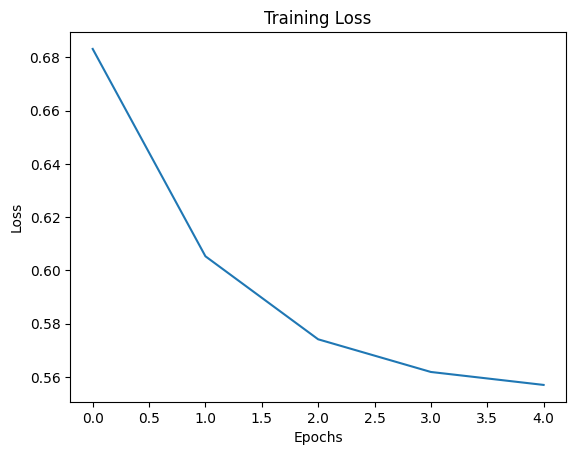

In [11]:
%matplotlib inline
plt.plot(train_loss)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

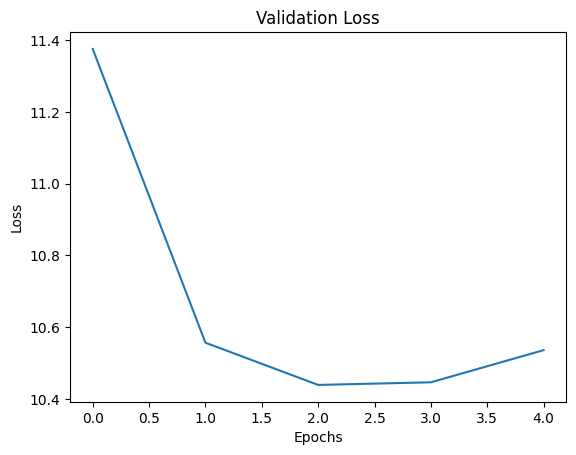

In [12]:
# Plotting
plt.plot(val_loss)
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [13]:
import pandas as pd
df = pd.read_csv('D:/FPT/SU24/DSP391m/code/crawl/data/clean/df_combine.csv')
test_df = df.iloc[3914:]
y_test = test_df.Sell.to_list()
test_df

,Date,Buy Cash,Buy Transfer,Sell,inflation_rate_vn,inflation_rate_us,fdi_vn,fdi_us
3914,2023-09-27,24170.0,24200.0,24540.0,0.0366,0.037,13.530000,72.8
3915,2023-09-28,24190.0,24220.0,24560.0,0.0366,0.037,13.530000,72.8
3916,2023-09-29,24090.0,24120.0,24460.0,0.0366,0.037,13.530000,72.8
3917,2023-09-30,24090.0,24120.0,24460.0,0.0366,0.037,13.530000,72.8
3918,2023-10-01,24090.0,24120.0,24460.0,0.0359,0.032,20.476667,66.4
...,...,...,...,...,...,...,...,...
4005,2023-12-27,24110.0,24140.0,24480.0,0.0358,0.034,20.476667,66.4
4006,2023-12-28,24030.0,24060.0,24400.0,0.0358,0.034,20.476667,66.4
4007,2023-12-29,24050.0,24080.0,24420.0,0.0358,0.034,20.476667,66.4
4008,2023-12-30,24050.0,24080.0,24420.0,0.0358,0.034,20.476667,66.4


In [14]:
# Flatten the 3D array to 1D and convert to list
pred_flattened = real_pred.flatten().tolist()
len(pred_flattened)

96

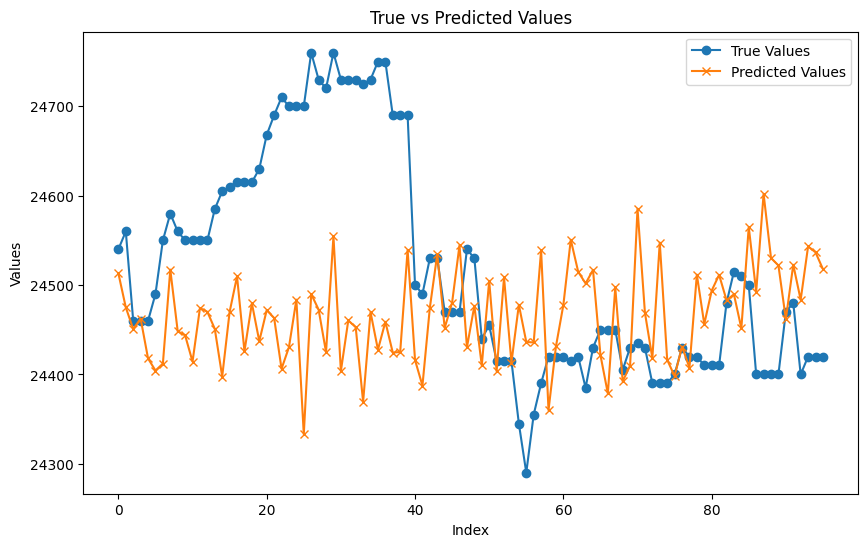

In [15]:
# Ensure y_test and pred_flattened are the same length
assert len(y_test) == len(pred_flattened), "Lengths of y_test and pred do not match!"

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values', marker='o')
plt.plot(pred_flattened, label='Predicted Values', marker='x')
plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()